## Customer Churn Prediction & Retention Strategy 

This project delivers an end-to-end analysis of customer churn for an e-commerce platform. It uncovers key drivers behind customer attrition through in-depth exploratory data analysis, transforms raw data with feature engineering, and applies machine learning models to predict churn probability. The findings are supported with performance evaluation metrics and practical recommendations to help businesses implement effective retention strategies.

## Importing necessary libraries

In [4]:
# Data Handling
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data Imputing
from sklearn.impute import KNNImputer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [5]:
ecom = pd.read_excel("E Commerce Dataset.xlsx", sheet_name=1)

In [6]:
ecom.shape

(5630, 20)

In [7]:
df = ecom.copy()
ecom.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [8]:
ecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [9]:
# Percentage of Missing Values
round(ecom.isnull().sum()/ecom.shape[0] * 100, 2)

CustomerID                     0.00
Churn                          0.00
Tenure                         4.69
PreferredLoginDevice           0.00
CityTier                       0.00
WarehouseToHome                4.46
PreferredPaymentMode           0.00
Gender                         0.00
HourSpendOnApp                 4.53
NumberOfDeviceRegistered       0.00
PreferedOrderCat               0.00
SatisfactionScore              0.00
MaritalStatus                  0.00
NumberOfAddress                0.00
Complain                       0.00
OrderAmountHikeFromlastYear    4.71
CouponUsed                     4.55
OrderCount                     4.58
DaySinceLastOrder              5.45
CashbackAmount                 0.00
dtype: float64

## Data Cleaning

#### Categorical : Removing Duplicates

In [12]:
cat_cols = ecom.dtypes[ecom.dtypes == 'object'].index

for i in cat_cols:
    print(f"{i} ---> {ecom[i].unique()}")
    print()

PreferredLoginDevice ---> ['Mobile Phone' 'Phone' 'Computer']

PreferredPaymentMode ---> ['Debit Card' 'UPI' 'CC' 'Cash on Delivery' 'E wallet' 'COD' 'Credit Card']

Gender ---> ['Female' 'Male']

PreferedOrderCat ---> ['Laptop & Accessory' 'Mobile' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']

MaritalStatus ---> ['Single' 'Divorced' 'Married']



In [13]:
# Change values to lower and replace space with _ for cleaning
for i in cat_cols:
    ecom[i] = ecom[i].apply(lambda x: x.lower().replace(" ", "_"))

In [14]:
# Replacing duplicate values
ecom["PreferredLoginDevice"].replace("phone", "mobile_phone", inplace = True)
ecom["PreferredPaymentMode"].replace(["cc", "cod"], ["credit_card", "cash_on_delivery"], inplace = True)
ecom["PreferedOrderCat"].replace("mobile_phone", "mobile", inplace = True)

In [15]:
# Checking if all values are replaced
for i in cat_cols:
    print(f"{i} ---> {ecom[i].unique()}")
    print()

PreferredLoginDevice ---> ['mobile_phone' 'computer']

PreferredPaymentMode ---> ['debit_card' 'upi' 'credit_card' 'cash_on_delivery' 'e_wallet']

Gender ---> ['female' 'male']

PreferedOrderCat ---> ['laptop_&_accessory' 'mobile' 'others' 'fashion' 'grocery']

MaritalStatus ---> ['single' 'divorced' 'married']



#### Numerical : Imputing missing values using KNN Imputer

In [17]:
# Encoding before imputing missing values
ecom_encoded = pd.get_dummies(ecom, drop_first = True)

In [18]:
# Using KNN Imputer
impute = KNNImputer(n_neighbors = 5)
ecom_imputed = impute.fit_transform(ecom_encoded)

In [19]:
# Converting the imputed array to dataframe
ecom_imputed = pd.DataFrame(ecom_imputed, columns = ecom_encoded.columns)

In [20]:
# Replacing the old columns with imputed values for analysis
missing_cols = ecom.isnull().sum()[ecom.isnull().sum() > 0].index

for i in missing_cols:
    ecom[i] = ecom_imputed[i]

## EDA

**Percentage of Customers who Left**

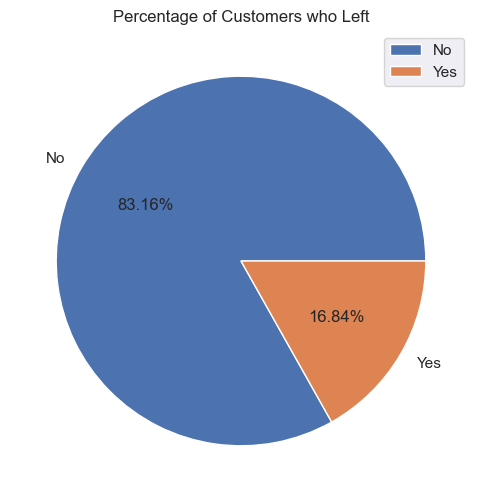

In [23]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [15,6])

percent_count = ecom['Churn'].value_counts(normalize = True)
ax.pie(x = ecom['Churn'].value_counts(),labels = ["No", "Yes"], autopct = lambda percent_count: '{:.2f}%'.format(percent_count))
ax.set_title('Percentage of Customers who Left', fontsize = 12)
ax.legend()

plt.show()

**Customer Satisfaction**: The high overall retention rate indicates that most customers are happy with the service, likely due to strong product quality, competitive pricing, and effective support.

**Areas for Improvement**: The 16.84% churn rate highlights room for growth. Analyzing the root causes of customer attrition can guide targeted interventions to reduce churn and boost loyalty.

**Customer Churn by Gender**

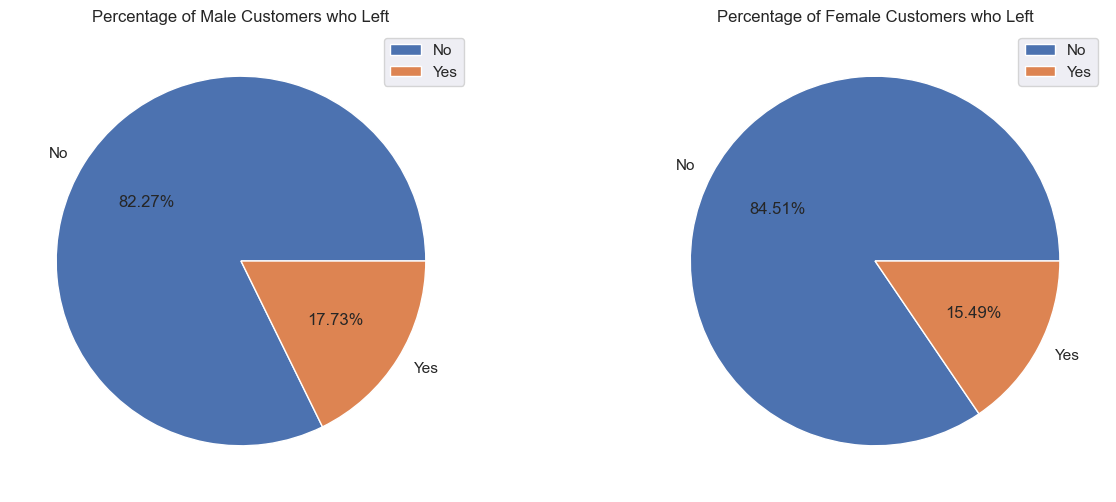

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = [15,6])

percent_count = ecom[ecom["Gender"] == "male"]['Churn'].value_counts(normalize = True)
ax1.pie(x = ecom[ecom["Gender"] == "male"]['Churn'].value_counts(),labels = ["No", "Yes"], autopct = lambda percent_count: '{:.2f}%'.format(percent_count))
ax1.set_title('Percentage of Male Customers who Left', fontsize = 12)
ax1.legend()

percent_count = ecom[ecom["Gender"] == "female"]['Churn'].value_counts(normalize = True)
ax2.pie(x = ecom[ecom["Gender"] == "female"]['Churn'].value_counts(),labels = ["No", "Yes"], autopct = lambda percent_count: '{:.2f}%'.format(percent_count))
ax2.set_title('Percentage of Female Customers who Left', fontsize = 12)
ax2.legend()

plt.show()

**Customer Satisfaction**: Both male and female customers exhibit strong retention, reflecting overall satisfaction. However, female customers show slightly higher loyalty levels.

**Targeted Strategies**: The relatively higher churn among male customers indicates an opportunity to design targeted engagement and retention campaigns for this segment.



**Customer Churn by Tenure Range**

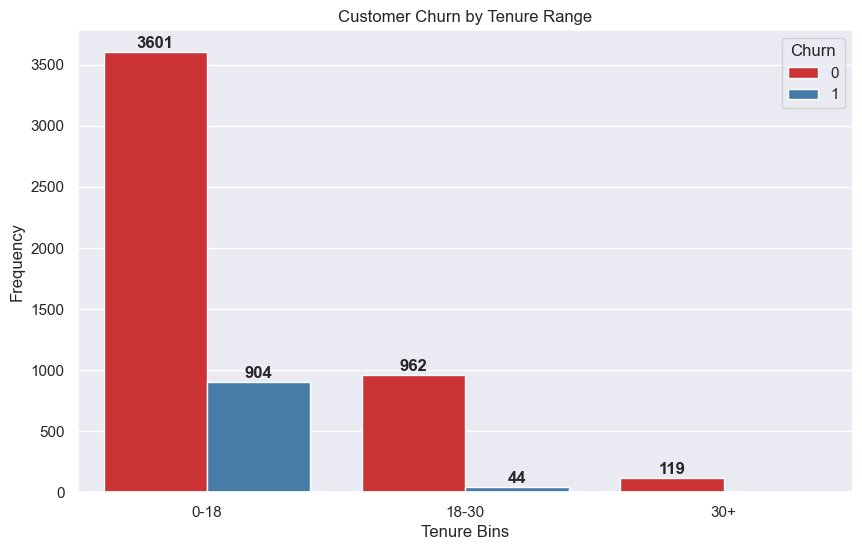

In [29]:
# Creating Tenure Groups
bins = [0, 18, 30, np.inf]
labels = ['0-18', '18-30', '30+']
ecom['TenureRange'] = pd.cut(ecom['Tenure'], bins = bins, labels = labels, right = False, include_lowest = True)

plt.figure(figsize=(10,6))
ax = sns.countplot(data = ecom, x = 'TenureRange', hue = 'Churn', palette = 'Set1')

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha = 'center', va = 'baseline', 
                    xytext = (0, 3), weight = 'bold',
                    textcoords = 'offset points')

plt.title('Customer Churn by Tenure Range')
plt.xlabel('Tenure Bins')
plt.ylabel('Frequency')
plt.show()


**Early Engagement**: New customers show high variability in spending, emphasizing the need for strong onboarding and engagement strategies to stabilize and increase spending.

**Mid-Tenure Challenges**: Spending often dips around the 30-month mark, indicating potential challenges in keeping customers engaged. Addressing these issues proactively can help maintain consistent spending.

**Long-Term Engagement**: Even loyal customers may experience periods of lower engagement, as reflected in long-term spending fluctuations. Regularly refreshing engagement strategies can help sustain steady spending.
lue**.
time value.


**Average Estimated Monthly Spending by Tenure**

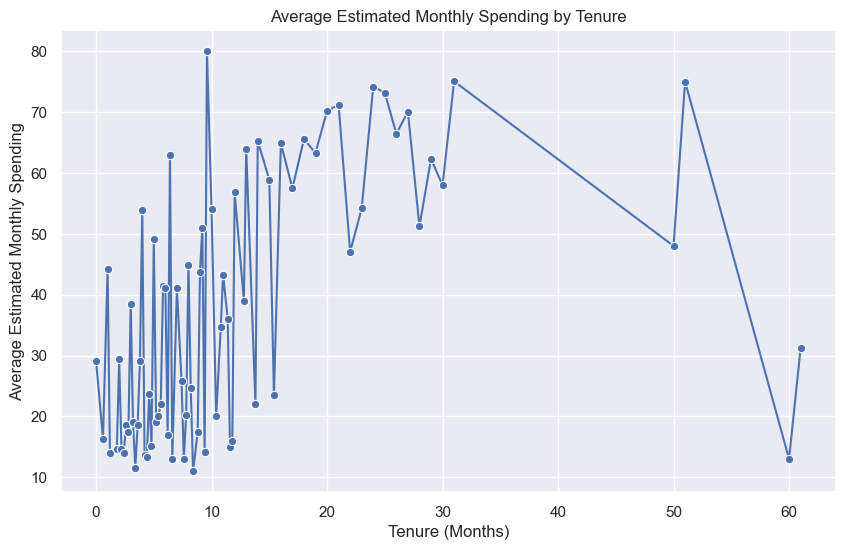

In [32]:
ecom['EstimatedMonthlySpending'] = ecom['OrderCount'] * ecom['OrderAmountHikeFromlastYear']
tenure_spending_avg = ecom.groupby('Tenure')['EstimatedMonthlySpending'].mean().reset_index()

plt.figure(figsize = (10,6))
sns.lineplot(data = tenure_spending_avg, x = 'Tenure', y = 'EstimatedMonthlySpending', marker = 'o')
plt.title('Average Estimated Monthly Spending by Tenure')
plt.xlabel('Tenure (Months)')
plt.ylabel('Average Estimated Monthly Spending')
plt.show()


**Early Engagement**: New customers display high variability in spending, highlighting the importance of strong onboarding and engagement strategies to stabilize and gradually increase spending.

**Mid-Tenure Challenges**: Spending tends to dip around the 30-month mark, suggesting potential difficulties in keeping customers engaged and satisfied. Proactively addressing these challenges can help maintain consistent spending.

**Long-Term Engagement**: Even loyal customers may go through periods of lower engagement, as seen in fluctuations in long-term spending. Regularly updating engagement strategies can help sustain steady spending over time.
me.


**Churn by Satisfaction Score**

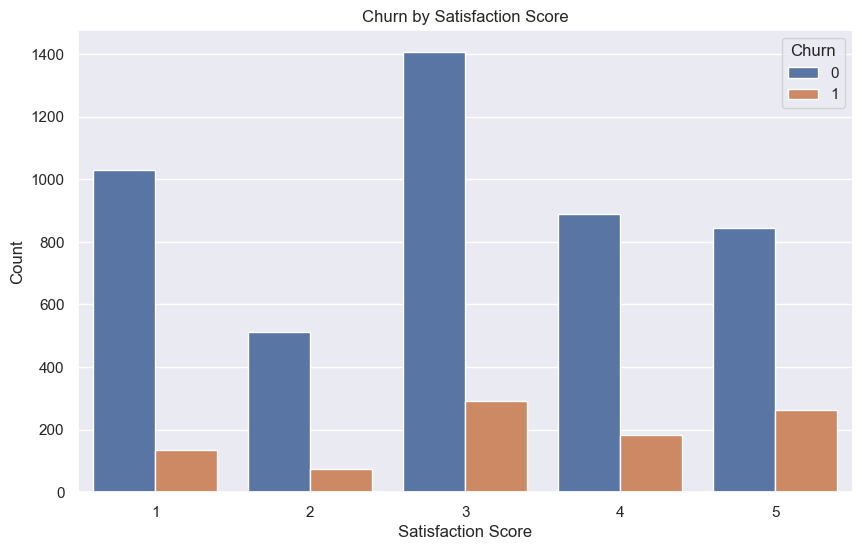

In [35]:
plt.figure(figsize = (10,6))
sns.countplot(data = ecom, x = 'SatisfactionScore', hue = 'Churn')
plt.title('Churn by Satisfaction Score')
plt.xlabel('Satisfaction Score')
plt.ylabel('Count')
plt.legend(title = 'Churn')
plt.show()

**Retention Despite Low Satisfaction**: The high retention rates among customers with low satisfaction scores could indicate that these customers might be staying due to lack of alternatives or other factors not directly related to satisfaction.

**Importance of Satisfaction**: The trend of decreasing churn with higher satisfaction scores underscores the importance of maintaining high customer satisfaction to reduce churn rates.
.


**Order Amount Hike by City Tier and Satisfaction Score**

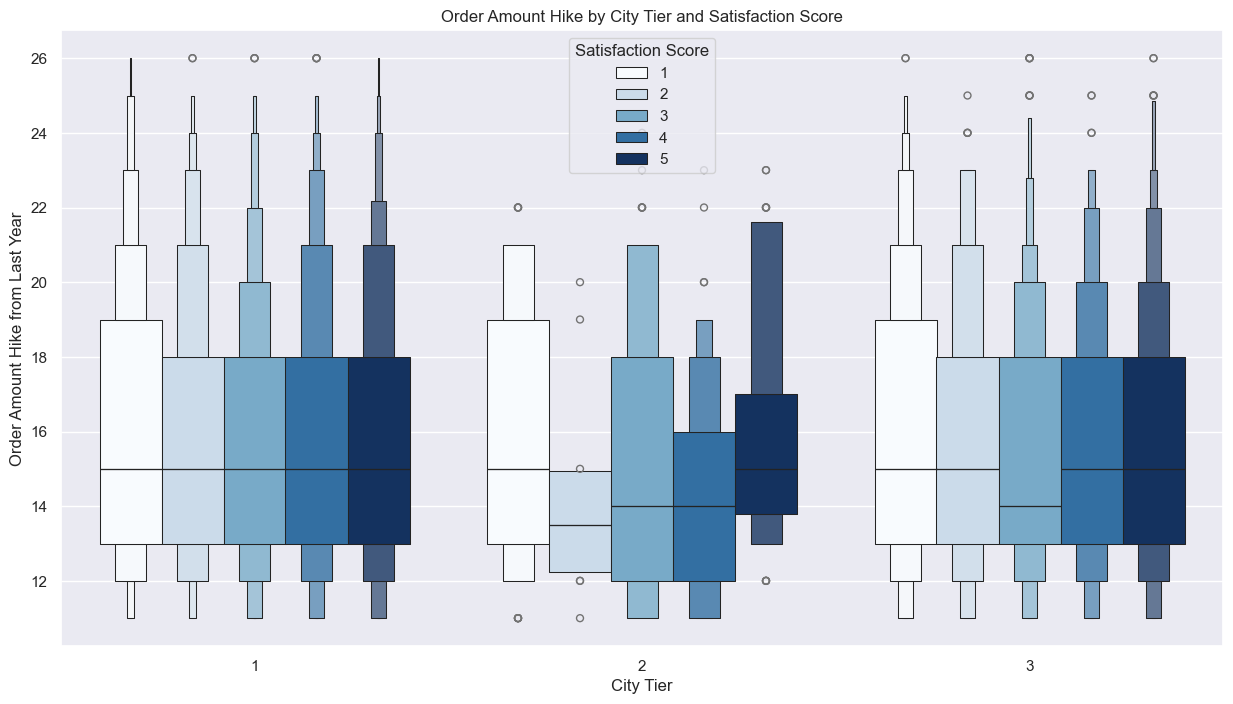

In [38]:
plt.figure(figsize=(15,8))
sns.boxenplot(data=ecom, x='CityTier', y='OrderAmountHikeFromlastYear', hue='SatisfactionScore', palette='Blues')
plt.title('Order Amount Hike by City Tier and Satisfaction Score')
plt.xlabel('City Tier')
plt.ylabel('Order Amount Hike from Last Year')
plt.legend(title='Satisfaction Score', loc = "upper center")
plt.show()

**Customer Behavior by City Tier**: Spending patterns vary more among customers in higher-tier cities (Tier 1), likely reflecting differences in economic conditions and purchasing power.

**Satisfaction and Spending Stability**: Customers who report higher satisfaction tend to spend more consistently, showing less sensitivity to changes in order amounts.
.


**Pairplot of Continuous Variables by Churn Status**

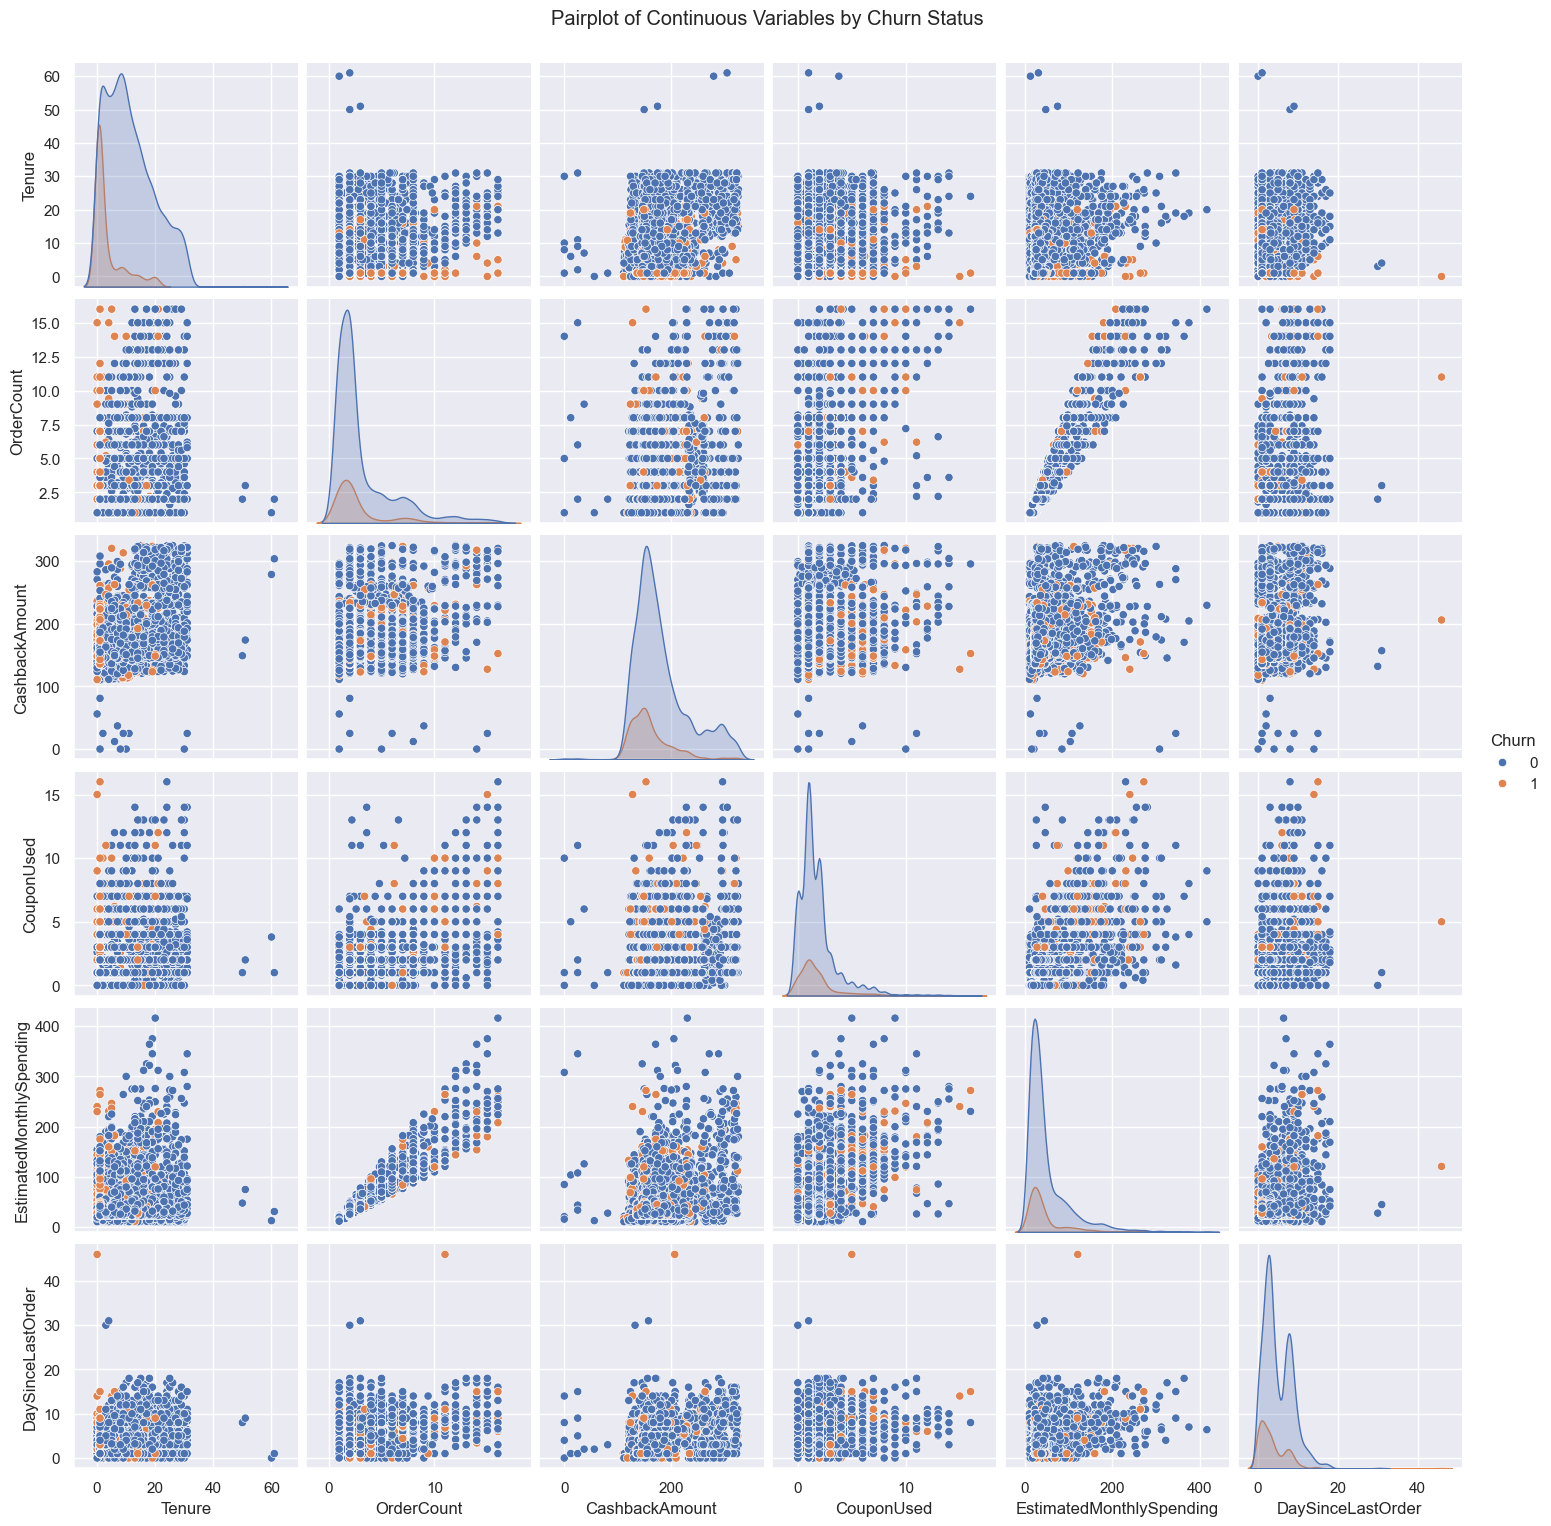

In [41]:
sns.pairplot(ecom, vars=['Tenure', 'OrderCount', 'CashbackAmount', 'CouponUsed','EstimatedMonthlySpending', 'DaySinceLastOrder'], hue = 'Churn')
plt.suptitle('Pairplot of Continuous Variables by Churn Status', y = 1.02)
plt.show()

**Targeted Retention Strategies**: Prioritize retention efforts for customers with shorter tenures and higher monthly charges. Personalized offers or discounts can help lower churn in these segments.

**Demographic-Specific Interventions**: Create tailored strategies for senior citizens and customers without partners or dependents to address their unique needs and reduce churn.

**Service Optimization**: Assess how phone service and multiple lines affect customer satisfaction and churn. Offering bundled services or incentives to customers with multiple lines may improve retention.


## Fitting models to the Data

In [44]:
x = ecom.drop(columns = ["CustomerID", "Churn", "EstimatedMonthlySpending", "TenureRange"])
X = pd.get_dummies(x, drop_first = True)
y = ecom["Churn"]

In [45]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

**Logistic Regression**

In [47]:
log = LogisticRegression(random_state = 123)
log.fit(x_train, y_train)

LogisticRegression(random_state=123)

In [48]:
y_pred = log.predict(x_test)

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       938
           1       0.72      0.53      0.61       188

    accuracy                           0.89      1126
   macro avg       0.82      0.75      0.77      1126
weighted avg       0.88      0.89      0.88      1126



<Axes: >

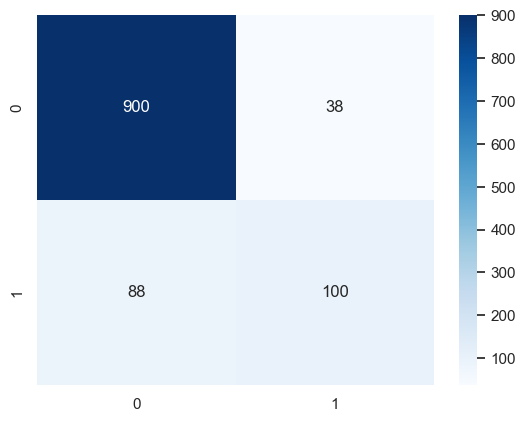

In [50]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = ".5g", cmap = "Blues")

**Decision Tree**

In [52]:
dt = DecisionTreeClassifier(random_state = 123)
dt.fit(x_train, y_train)

DecisionTreeClassifier(random_state=123)

In [53]:
y_pred = dt.predict(x_test)

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       938
           1       0.82      0.87      0.84       188

    accuracy                           0.95      1126
   macro avg       0.90      0.91      0.90      1126
weighted avg       0.95      0.95      0.95      1126



<Axes: >

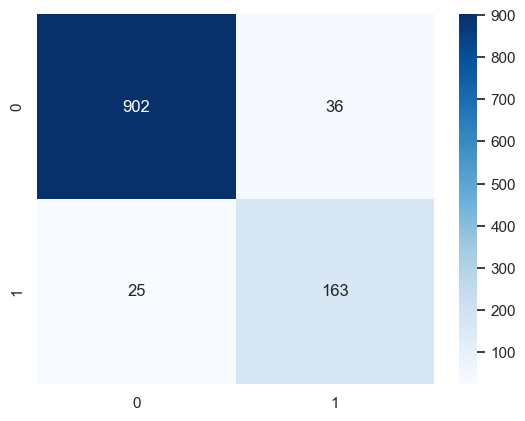

In [55]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = ".5g", cmap = "Blues")

**Random Forest**

In [57]:
rf = RandomForestClassifier(random_state = 123)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=123)

In [58]:
y_pred = rf.predict(x_test)

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       938
           1       0.96      0.84      0.89       188

    accuracy                           0.97      1126
   macro avg       0.97      0.91      0.94      1126
weighted avg       0.97      0.97      0.97      1126



<Axes: >

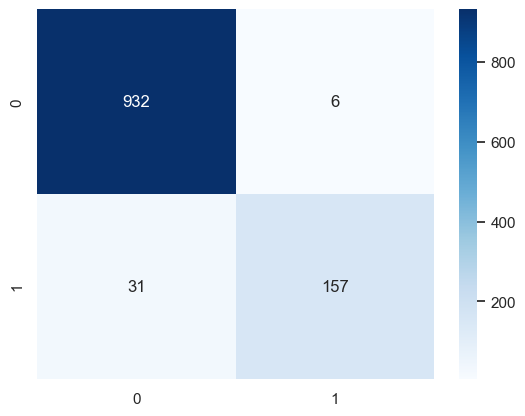

In [60]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = ".5g", cmap = "Blues")

In [61]:
# Predicting the whole dataset using the model
Y_pred = rf.predict(X)

In [62]:
# Creating a dataset with customers corresponding to the predictions
new_df = pd.concat((ecom['CustomerID'], pd.Series(Y_pred)), axis = 1)
new_df.columns = ["CustomerID", "Churn"]
new_df.head()

,CustomerID,Churn
0,50001,1
1,50002,1
2,50003,1
3,50004,1
4,50005,1


In [63]:
new_df[new_df['Churn'] == 1]

,CustomerID,Churn
0,50001,1
1,50002,1
2,50003,1
3,50004,1
4,50005,1
...,...,...
5556,55557,1
5598,55599,1
5602,55603,1
5604,55605,1


- According to the model, **923 customers** from the dataset, identified by their corresponding IDs, are likely to churn in the future.


## Marketing Strategy

- Most customers tend to leave within the first few months of service, possibly because they find better alternatives. Gaining a deeper understanding of competitors and offering attractive deals to new customers can help improve retention.

- Actively collecting feedback from early churners and offering flexible plans in cities with lower customer satisfaction scores can further reduce churn.

- Regular follow-ups with recently joined customers can enhance their perception of the company and encourage referrals.
